# Example of using The Module Formerly Known as KDE and Asy_peakbag
This is a notebook showing a rough draft of the replacement module for KDE and Asy_peakbag, which is currently WIP on the PBjam-dev branch.

We'll start by importing the modeID sampler (Should the name be changed?)

In [1]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO
import pbjam.distributions as dist
import matplotlib.pyplot as plt
import astropy.convolution as conv
import numpy as np

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
psd = IO.psd('KIC8228742', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

psd()

f = psd.freq[::10]

s = psd.powerdensity[::10]

Using cached search result.
Loading fits files from cache.


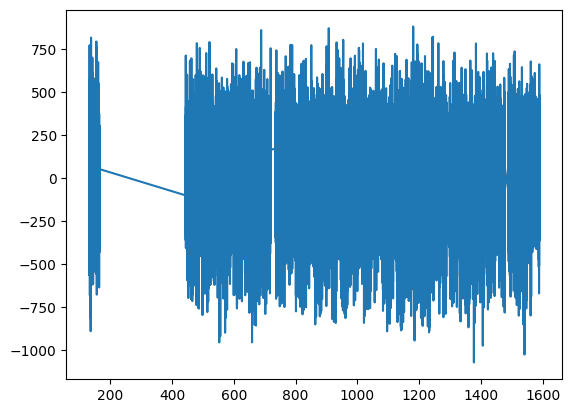

In [3]:
plt.plot(psd._time, psd._flux)

In [4]:

addPriors = {'p_L0': dist.normal(loc=np.log10(0.074), scale=0.1),
             'p_D0': dist.normal(loc=np.log10(0.0016), scale=0.1),
             'DPi0': dist.normal(loc=0.000846, scale=0.000446*0.1),
             'eps_g': dist.normal(loc=0.79, scale=0.01),
             'd01': dist.normal(loc=np.log10(26), scale=0.1),
             'alpha_g': dist.normal(loc=np.log10(0.02), scale=0.1),
            }

These location and scale parameters for the priros are suitable for a cool MS star. The g-mode parameters are of course non-sense, and all fits to MS stars just recover this prior since the p-modes can't feel any of the g-modes yet. For lower numax targets, the prior parameters must be chosen by hand (see the bottom of this notebook).

The pbjam.distributions module contains a short list of 'standard' distributions,these include normal, uniform, beta and a few others.. The jax.scipy.stats module could replace some of these functions, but they are far from complete (many don't have a ppf method for example). If you want to construct your own distribution you can do so, although it must have a ppf method which is required by Dynesty.

If you wish to add a distribution as a prior, you'll need to use the correct keyword as everything is now keyword-based rather than index-based. You can view a list of all keywords for the model parameters, whether they are treated in log10 or not and whether they are included in the DR by default in the `modeIDsampler.variables` attribute of the sampler class. You can edit this before initializing the class below in case you want to set a parameter to log10, but you won't need to edit things if you're just adding priors. This will be handled automatically. **Ideally you won't need to edit this at all**

Apart from those listed above, the shot noise and the very lowest frequency harvey law have hardcoded priors. It's safe to ignore these for now. 

## Additional observational parameters
As in the earlier PBjam versions we use additional observational parameters. $\nu_{max}$, $\Delta\nu$ and $T_{eff}$ are used to select the prior sub-sample to construct the covariance matrix for DR, while $T_{eff}$ and $G_{bp}-G_{rp}$ are used in the actual sampling as additional log-likelihood terms.

In [5]:
addObs = {'numax': (1127.014086, 100),
          'dnu'  : (61.618306, 0.54),
          'teff' : (6042.0, 77),
          'bp_rp': (0.727789, 0.05),
          } 

## Initialize the sampler
We can now initialize the sampler class. This requires specifying the number of orders `N_p` (previously `norders`) to include in the model. In addition we also set the number of targets (`N_pca`) to draw from the prior sample to construct covariance matrix for DR, and the number of dimensions (`PCAdims`) to use in the sampling.  

TODO: add in a check that `PCAdims` + non-PCA dims <= all model parameters.

In [6]:
N_p = 10

N_pca = 20

PCAdims = 8
 
M = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath())

In [7]:
M.MixFreqModel.n_g

Array([1], dtype=int64)

## Plot the prior
It's always good to check that your prior is reasonable, so lets plot some samples from the prior.

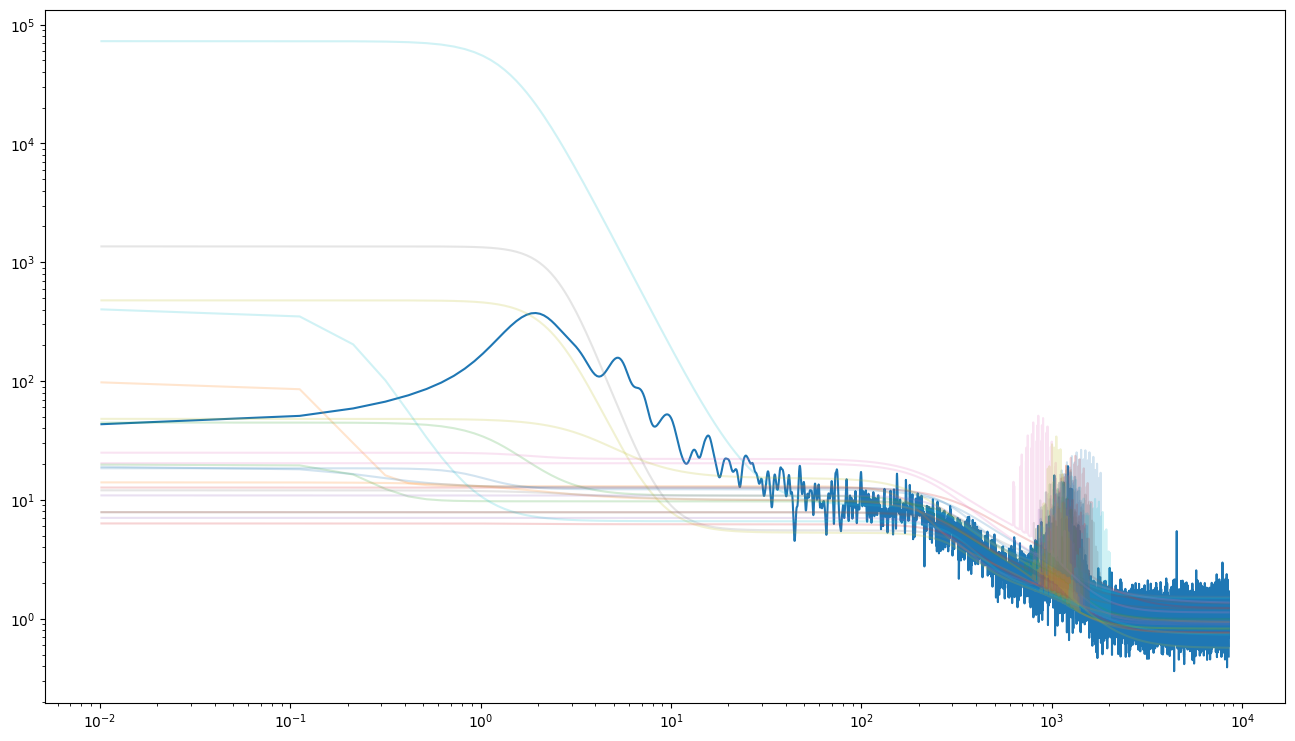

In [8]:
fac = max([1, 0.5 / (M.f[1] - M.f[0])])
kernel = conv.Gaussian1DKernel(stddev=np.array(fac))
smoo = conv.convolve(M.s, kernel)

N = 20

fig, ax = plt.subplots(figsize=(16,9))

ax.loglog(M.f, smoo)

for i in range(N):
    u = np.random.uniform(0, 1, size=M.ndims)

    theta = M.ptform(u)
    
    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.loglog(M.f, m, alpha = 0.2)

## Run Dynesty
Time to run! You can optionally run with the dynamic sampler enabled, but it probably won't do you much good and take an order of magnitude longer.

In [9]:
sampler, samples = M(dynesty_kwargs = {'nlive':500})

23722it [18:30, 21.37it/s, +500 | bound: 307 | nc: 1 | ncall: 899770 | eff(%):  2.694 | loglstar:   -inf < -70012.670 <    inf | logz: -70059.592 +/-  0.311 | dlogz:  0.001 >  0.509]


## Plot model samples
Time to plot some of the posterior samples

(0.0, 20.0)

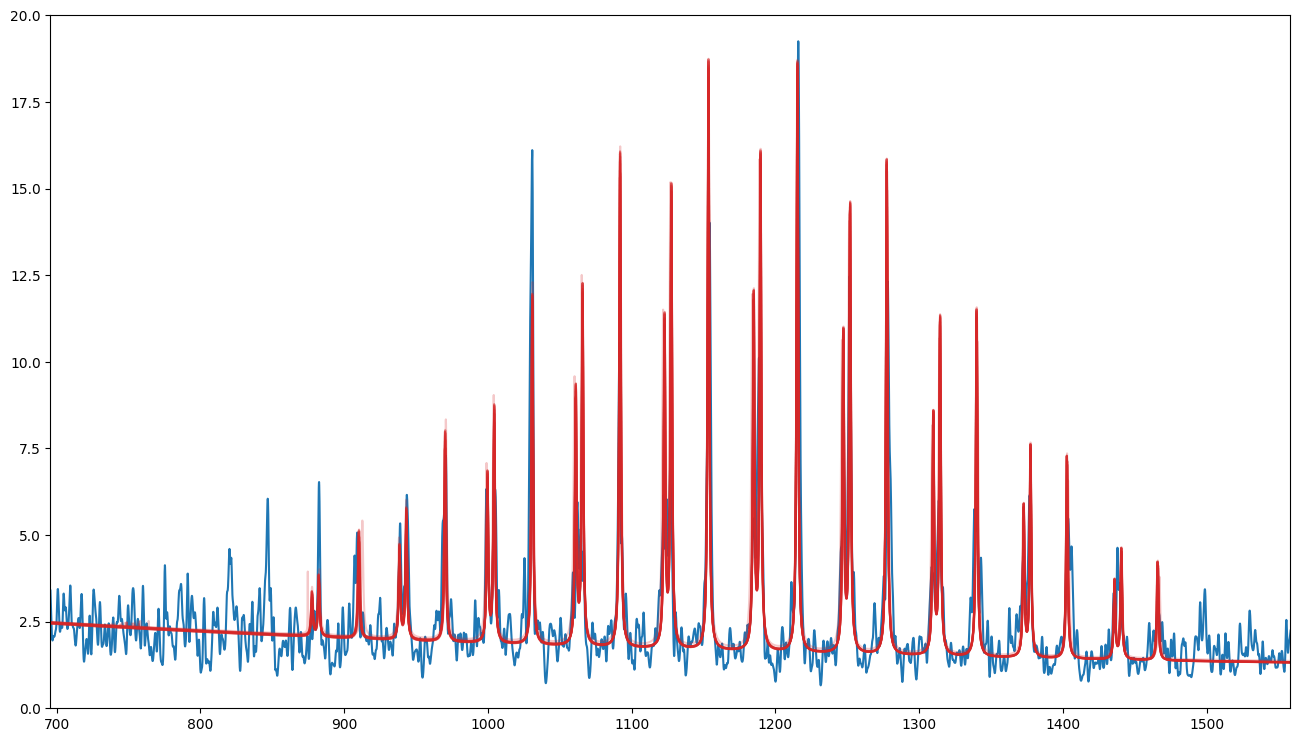

In [10]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(M.f, smoo)
 
N = 20
for i in np.random.randint(0, M.samples.shape[0], size=N):
    
    theta = M.samples[i, :]

    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.plot(M.f, m, color='C3', alpha=0.25)
    
ax.set_yscale('log')
ax.set_xscale('log')


fig, ax = plt.subplots(figsize=(16,9))
ax.plot(M.f, smoo)
 
for i in np.random.randint(0, M.samples.shape[0], size=N):
    
    theta = M.samples[i, :]

    theta_u = M.unpackParams(theta)
     
    m = M.model(theta_u, M.f)
    
    ax.plot(M.f, m, color='C3', alpha=0.25)
ax.set_xlim(addObs['numax'][0]-7*addObs['dnu'][0], addObs['numax'][0]+7*addObs['dnu'][0])
ax.set_ylim(0, 20)

## Corner plot
We can make a nice corner plot too. However, the samples from the priors contain a mix of latent parameters and model parameters, some in log10, others not. To get everything in terms of linear model parameters we'll need to transform the raw samples

In [11]:
samples_u = M.unpackSamples(M.samples)

In [12]:
M.result['summary']

{'freq': array([[8.82375918e+02, 9.43214450e+02, 1.00436662e+03, 1.06581487e+03,
         1.12756032e+03, 1.18959373e+03, 1.25191391e+03, 1.31452722e+03,
         1.37743590e+03, 1.44066640e+03, 7.57080541e+02, 9.10481573e+02,
         9.70371319e+02, 1.03091415e+03, 1.09197335e+03, 1.15344999e+03,
         1.21529519e+03, 1.27748215e+03, 1.33999754e+03, 1.40282376e+03,
         1.46596717e+03, 8.77669665e+02, 9.38514125e+02, 9.99679203e+02,
         1.06113131e+03, 1.12287392e+03, 1.18490339e+03, 1.24722374e+03,
         1.30983718e+03, 1.37274205e+03, 1.43593528e+03],
        [1.64201021e-01, 8.88559177e-02, 1.06265400e-01, 1.10642888e-01,
         1.16764076e-01, 1.20518433e-01, 1.18418180e-01, 1.12564164e-01,
         1.08034029e-01, 1.44482498e-01, 1.14167109e+01, 3.59621981e-01,
         2.11661213e-01, 1.18900626e-01, 8.72559083e-02, 7.96915854e-02,
         9.11684651e-02, 9.99480565e-02, 1.16373324e-01, 1.48134856e-01,
         2.03059926e-01, 1.18791867e-01, 1.07831049e-01, 1

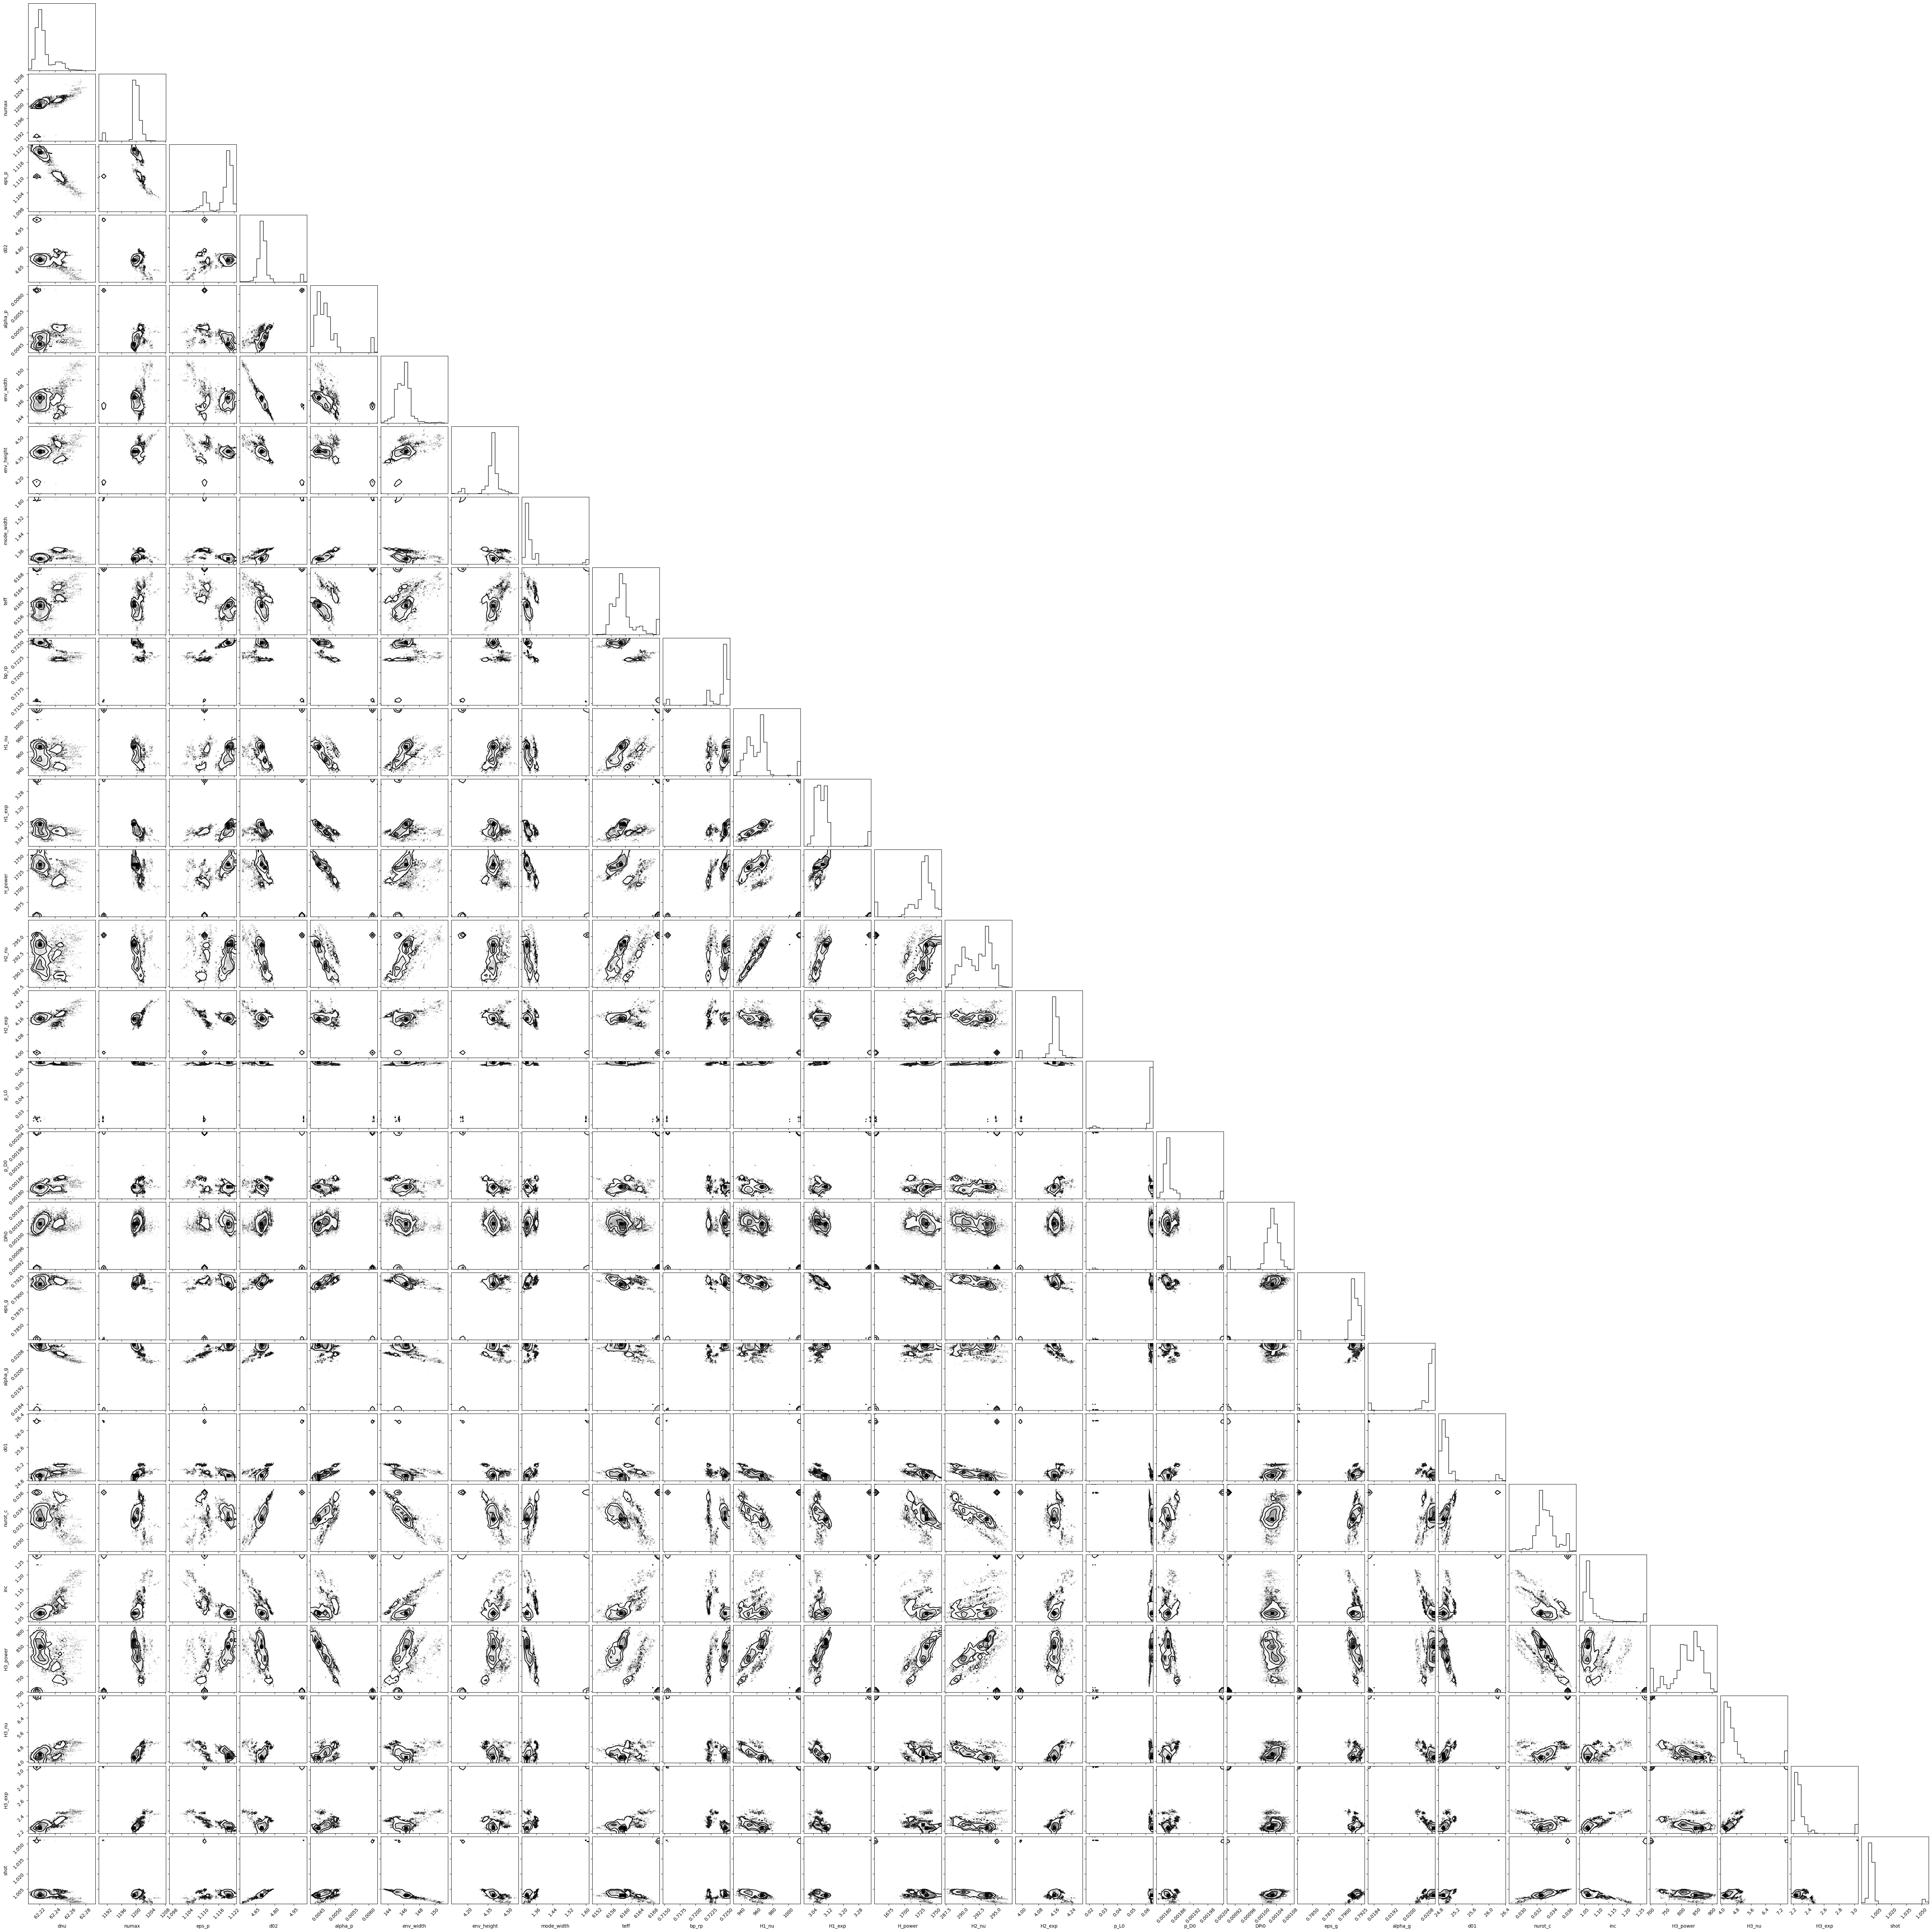

In [13]:
import corner
corner.corner(samples_u);

Or any subset.

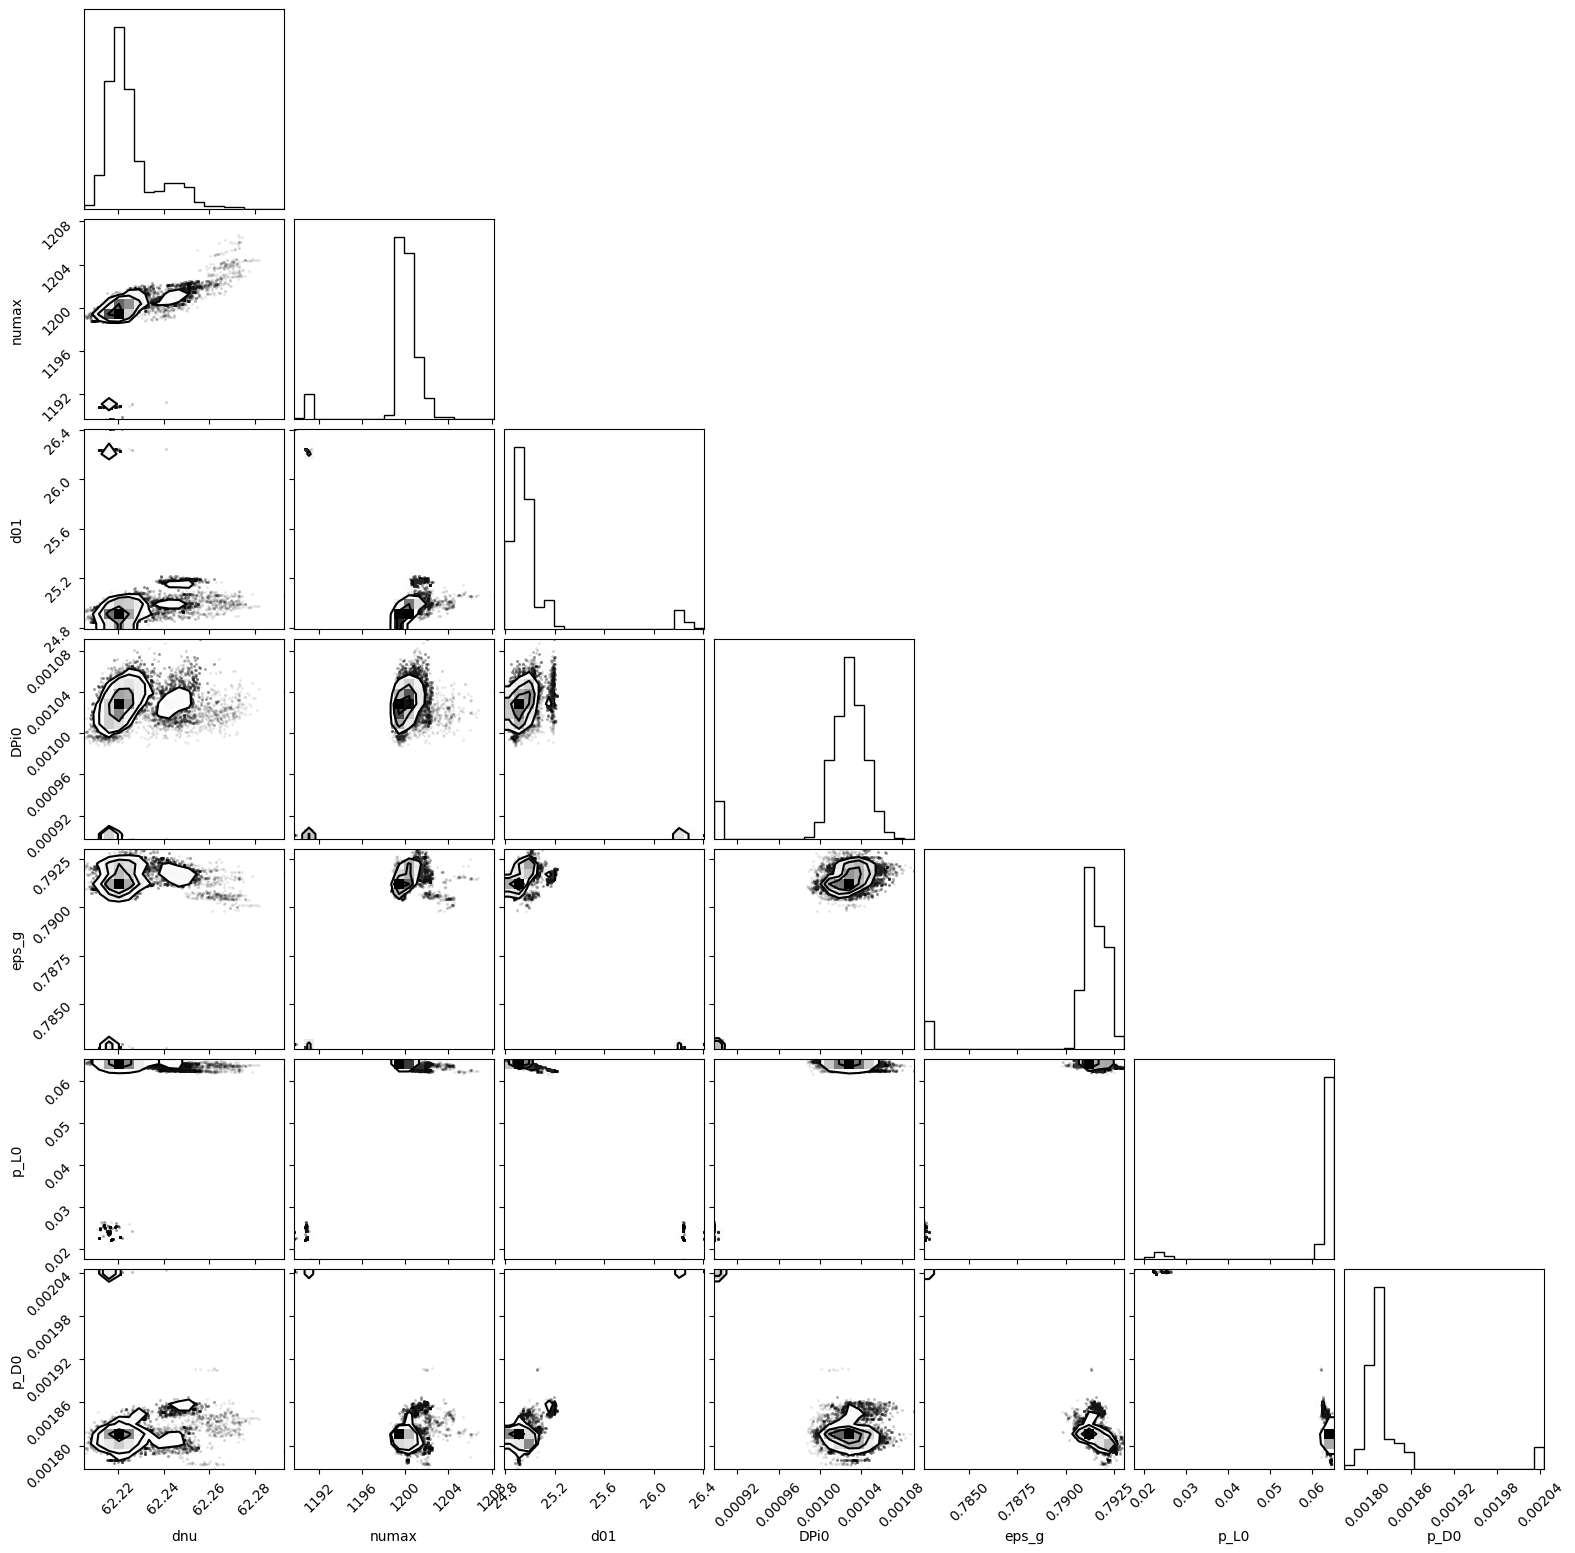

In [14]:
corner.corner({k : samples_u[k] for k in ['dnu', 'numax', 'd01', 'DPi0', 'eps_g', 'p_L0', 'p_D0']});

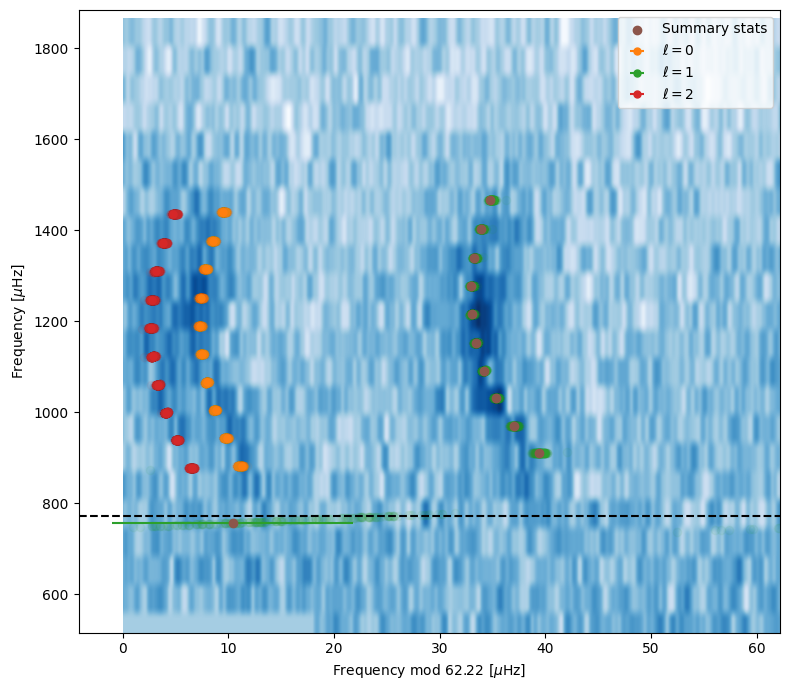

In [15]:
import jax.numpy as jnp

fig, ax = M.echelle();
 
d01 =  M.result['summary']['d01'][0] 
DPi0 =  M.result['summary']['DPi0'][0] 
eps_g = M.result['summary']['eps_g'][0] 
alpha_g = M.result['summary']['alpha_g'][0] 
p_L = jnp.array([M.result['summary']['p_L0'][0]  ])
p_D = jnp.array([M.result['summary']['p_D0'][0]])
numax = M.result['summary']['numax'][0]
dnu = M.result['summary']['dnu'][0]

eps_p = M.result['summary']['eps_p'][0]
alpha_p = M.result['summary']['alpha_p'][0]

nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(numax, dnu, eps_p, alpha_p)


nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, DPi0, eps_g, alpha_g )
 
nu_m, zeta = M.MixFreqModel.mixed_nu1(nu0_p, n_p, d01, DPi0, p_L, p_D, eps_g, alpha_g)

ax.scatter(nu_m%dnu, nu_m, c='C5', zorder=99, label='Summary stats')
ax.legend()


for nu in nu_g:
    ax.axhline(nu, color='k', ls='dashed')